# Non-linear equations

**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
- 2. [Derivative based methods](#toc2_)    
- 3. [Numerical derivative](#toc3_)    
- 4. [Another example](#toc4_)    
- 5. [Derivative free methods: Bisection](#toc5_)    
- 6. [Scipy](#toc6_)    
- 7. [Non-linear equation systems](#toc7_)    
  - 7.1. [Introduction](#toc7_1_)    
  - 7.2. [Newton's method](#toc7_2_)    
  - 7.3. [Using Scipy](#toc7_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

You will learn to find roots of non-linear equations numerically (**scipy.optimize**).

**scipy.optimize:** [overview](https://docs.scipy.org/doc/scipy/reference/optimize.html) + [turtorial](https://docs.scipy.org/doc/scipy/tutorial/optimize.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 12})
import ipywidgets as widgets

from scipy import linalg
from scipy import optimize

**Note:** The algorithms written here are meant to be illustrative. The scipy implementations are always both the *fastest* and the *safest* choice.

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

In economics, we really like setting **First Order Conditions** to 0. We do it every time we want to solve for optimal behavior.

Therefore, we often want to **solve non-linear equations** on the form,

$$ 
f(x) = 0, x \in \mathbb{R} 
$$

There are 2 types of method:
* **Derivative based:** More robust and takes fever steps.
* **Derivative free:** Less numerically stable, but does not require a gradient, so often easier to implement. 

A simple **example** of a function for our root finding:

$$
f(x) = -x^3 + 2x^2 + 4x + 30 
$$

## 2. <a id='toc2_'></a>[Derivative based methods](#toc0_)

**Newton's method**: 

We use a **first order** Taylor approximation of the function at a **new point** $x_1$:

$$ 
f(x_1) \approx f(x_0) + f^{\prime}(x_0)(x_1-x_0)
$$

We choose $x_1$ from where the Taylor approximation is zero: 

$$
f(x_1) = 0 \Leftrightarrow x_1 = x_0 - \frac{f(x_0)}{f^{\prime}(x_0)}
$$

**Algorithm:** `find_root()`

1. Choose tolerance $\epsilon > 0$, guess on $x_0$ and set $k = 0$.
2. Calculate $f(x_k)$ and $f^{\prime}(x_k)$.
3. If $|f(x_k)| < \epsilon$ then stop.
4. Calculate new candidate $x_{k+1} = x_k - \frac{f(x_k)}{f^{\prime}(x_k)}$.
5. Set $k = k + 1$ and return to step 2.

In [2]:
def find_root(x0,f,df,max_iter=500,tol=1e-8,full_info=False):
    """ find root
        
    Args:
    
        x0 (float): initial value
        f (callable): function
        df (callable): derivative
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        full_info (bool): controls information returned
        
    Returns:
    
        x (float/ndarray): root (if full_info, all x tried)
        k (int): number of iterations used
        fx (ndarray): function values used (if full_info) 
        fpx (ndarray): derivative values used (if full_info)
        
    """
    
    # initialize
    xs = []
    fxs = []
    dfxs = []
    
    # iterate
    x_k = x0    
    k = 0    
    while True:
        
        x = x_k

        # step 2: evaluate function and derivatives
        fx = f(x)
        dfx = df(x)
        
        # store info
        xs.append(x)
        fxs.append(fx)
        dfxs.append(dfx)

        # step 3: check convergence
        if abs(fx) < tol or k >= max_iter:
            break
            
        # step 4: update x
        x_k = x - fx/dfx
        
        # step 5: increment counter
        k += 1
        
    # return
    if full_info:
        return np.array(xs),k,np.array(fxs),np.array(dfxs)
    else:
        return x,k

**Pause:** Spend some time looking at the function above.

**Note:** The cell below contains a function for plotting the convergence.

In [3]:
def plot_find_root(x0,f,fp,xmin=-8,xmax=8,xn=100):
    
    # a. find root and return all information 
    x,max_iter,fx,fpx = find_root(x0,f,df=fp,full_info=True)
    
    # b. compute function on grid
    xvec = np.linspace(xmin,xmax,xn)
    fxvec = f(xvec)
    
    # c. figure
    def _figure(k):
        
        # i. approximation
        fapprox = fx[k] + fpx[k]*(xvec-x[k])
            
        # ii. figure
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(xvec,fxvec) # on grid
        ax.plot(x[k],0,'o',color='blue',mfc='none',label='$x_{k}$')# now
        ax.plot(xvec,fapprox) # approximation
        ax.plot(x[k],fx[k],'o',color='black',label='$f(x_k)$') # now       

        ax.axhline(0,ls='-',lw=1,color='black') # coordinate system
        ax.axvline(0,ls='-',lw=1,color='black') # coordinate system
        
        if k+1 < len(x):
            ax.axvline(x[k+1],ls='--',lw=1,color='black') # cross zero
            ax.plot(x[k+1],0,'o',color='green',mfc='none',label='$x_{k+1}$') # next
                
        ax.legend(loc='upper left',facecolor='white',ncols=3,frameon=True)
        ax.set_ylim(min([fxvec[-1],fxvec[0]]),max([fxvec[-1],fxvec[0]]))
    
    widgets.interact(_figure,
        k=widgets.IntSlider(description="iterations", min=0, max=max_iter, step=1, value=0)
    );

Illustrating rootfinding by Newton's methods

In [4]:
f = lambda x: -x**3 + 2*(x**2) + 4*x + 30 
df = lambda x: -3*(x**2) + 4*x + 4
x0 = -5.0

x,k = find_root(x0,f,df)
print(f'x = {x:.8f} [iterations: {k}]')
print(f'f(x) = {f(x)}')

x = 4.43084740 [iterations: 7]
f(x) = -2.3284130179490603e-10


In [5]:
plot_find_root(x0,f,df)

interactive(children=(IntSlider(value=0, description='iterations', max=7), Output()), _dom_classes=('widget-in…

## 3. <a id='toc3_'></a>[Numerical derivative](#toc0_)

Sometimes, you might not have the **analytical derivative**. Then, you can instead use the **numerical derivative**.

**Numerical derivative:** Define $\Delta$ to be a small number, then we approximate the derivative by 
$$
 \frac{df}{dx} \approx \frac{f(x+\Delta) - f(x)}{\Delta}
$$

In [6]:
# a. numerical derivative (forward)
Delta = 1e-8
fp_approx = lambda x: (f(x+Delta)-f(x))/Delta

# b. find root
x0 = -5.0
x,k = find_root(x0,f,fp_approx)
print(f'x = {x:.8f} [iterations: {k}]')
print(f'f(x) = {f(x)}')

x = 4.43084740 [iterations: 7]
f(x) = -2.374527241499891e-10


**Question:** What happens if you increase the stepsize to 1?  

## 4. <a id='toc4_'></a>[Another example](#toc0_)

In [7]:
g = lambda x: np.sin(x)
gp = lambda x: np.cos(x)

x0 = 4.0
plot_find_root(x0,g,gp)

interactive(children=(IntSlider(value=0, description='iterations', max=4), Output()), _dom_classes=('widget-in…

**Question:** What happens if the initial value is -2?

## 5. <a id='toc5_'></a>[Derivative free methods: Bisection](#toc0_)

Bisection is, like Newton's, an important root finding algorithm.

Look at the graph below. If $f(a) \times f(b) < 0$ then there must be a root in between $a$ and $b$. 

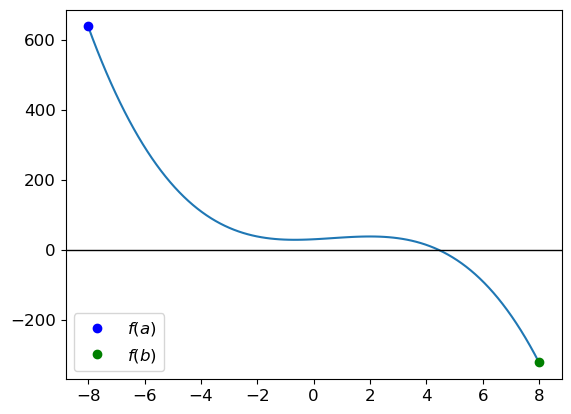

In [8]:
# a. x-values and function-values
xs = np.linspace(-8,8,100)
ys = f(xs)

# b. figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(xs,ys)
ax.axhline(0, ls='-',lw=1,color='black')
ax.plot(xs[0],ys[0],'o',color='blue',label='$f(a)$')
ax.plot(xs[-1],ys[-1],'o',color='green',label='$f(b)$')
ax.legend(loc='lower left',facecolor='white',frameon=True);
ax.grid(visible=None)

**Algorithm:** `bisection()`

1. Set $a_0 = a$ and $b_0 = b$ where $f(a)$ and $f(b)$ has oposite sign, $f(a_0)f(b_0)<0$
2. Compute $f(m_0)$ where $m_0 = (a_0 + b_0)/2$ is the midpoint.
3. Determine the next sub-interval $[a_1,b_1]$:
  * If $f(a_0)f(m_0) < 0$ (different signs) then $a_1 = a_0$ and $b_1 = m_0$ (i.e. focus on the range $[a_0,m_0]$).
  * If $f(m_0)f(b_0) < 0$ (different signs) then $a_1 = m_0$ and $b_1 = b_0$ (i.e. focus on the range $[m_0,b_0]$).
4. Repeat step 2 and step 3 until $|f(m_k)| < \epsilon$.

In [9]:
def bisection(f,a,b,max_iter=500,tol=1e-8,full_info=False):
    """ bisection
    
    Solve equation f(x) = 0 for a <= x <= b.
    
    Args:
    
        f (callable): function
        a (float): left bound
        b (float): right bound
        max_iter (int): maximum number of iterations
        tol (float): tolerance on solution
        full_info (bool): controls information returned
        
    Returns:
    
        m (float/ndarray): root (if full_info, all x tried)
        k (int): number of iterations used
        a (ndarray): left bounds used
        b (ndarray): right bounds used
        fm (ndarray): function values at midpoints
        
    """
    
    # test inputs
    if f(a)*f(b) >= 0:
        print("bisection method fails.")
        return None
    
    # initialize
    a_l = []
    b_l = []
    m_l = []
    fm_l = []
    
    # step 2-4: main
    k = 0
    while k < max_iter:
        
        # step 2: midpoint and associated value
        m = (a+b)/2
        fm = f(m)
        
        # store info
        a_l.append(a)
        b_l.append(b)
        m_l.append(m)
        fm_l.append(fm)
        
        # step 3: determine sub-interval
        if abs(fm) < tol:
            break        
        elif f(a)*fm < 0:
            b = m
        elif f(b)*fm < 0:
            a = m
        else:
            print("bisection method fails.")
            return None
        
        k += 1
        
    if full_info:
        # Returned lists are converted to np.arrays for good measure
        return np.array(m_l), k, np.array(a_l), np.array(b_l), np.array(fm_l)
    else:
        return m,k

**Run:**

In [10]:
m,k = bisection(f,-8,8)
print(k,m,f(m))

33 4.430847399868071 4.316270008075662e-09


**Same result** as before, but **trade-off** between more iterations and no evaluation of derivatives.

**Pause:** Spend some time looking at the function above.

**Note:** The cell below contains a function for plotting the convergence.

In [11]:
def plot_bisection(f,a,b,xmin=-8,xmax=8,xn=100):
    
    # a. find root and return all information 
    res = bisection(f,a,b,full_info=True)
    if res == None:
        return
    else:
        m,max_iter,a,b,fm = res
    
    # b. compute function on grid
    xvec = np.linspace(xmin,xmax,xn)
    fxvec = f(xvec)
    
    # c. figure
    def _figure(k):
        
        # ii. figure
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(xvec,fxvec) # on grid
        ax.axhline(y=0, xmin=xmin, xmax=xmax,color='black')
        ax.plot(m[k],fm[k],'o',color='black',label='current') # mid
        ax.plot([a[k],b[k]],[fm[k],fm[k]],'--',color='green',label='range') # range
        ax.axvline(a[k],ls='--',color='green')
        ax.axvline(b[k],ls='--',color='green')        
        
        ax.legend(loc='lower left',facecolor='white',frameon=True)
        ax.set_ylim(min([fxvec[-1],fxvec[0]]),max([fxvec[-1],fxvec[0]]))
    
    widgets.interact(_figure,
        k=widgets.IntSlider(description="iterations", min=0, max=max_iter-1, step=1, value=0)
    );

plot_bisection(f,-8,8)

interactive(children=(IntSlider(value=0, description='iterations', max=32), Output()), _dom_classes=('widget-i…

**Note:** Bisection is not good at the final convergence steps. Generally true for methods not using derivatives.

## 6. <a id='toc6_'></a>[Scipy](#toc0_)

Scipy, naturally, has better implementations of the above algorithms. 

You will most likely want to go for these when doing your own model solution.

**Newton:**

In [12]:
result = optimize.root_scalar(f,x0=-5.0,fprime=df,method='newton')
print(result)

      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 8
           root: 4.430847399984182


**Bisect:**

In [13]:
result = optimize.root_scalar(f,bracket=[-8,8],method='bisect')
print(result)

      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 43
           root: 4.430847399982667


The **best choice** is the more advanced **Brent-method**:

In [14]:
result = optimize.root_scalar(f,bracket=[-8,8],method='brentq')
print(result)

      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 4.430847399984182


## 7. <a id='toc7_'></a>[Non-linear equation systems](#toc0_)

### 7.1. <a id='toc7_1_'></a>[Introduction](#toc0_)

We consider **solving non-linear equations** on the form,

$$ 
f(\boldsymbol{x}) = f(x_1,x_2,\dots,x_k) = \boldsymbol{0}, \boldsymbol{x} \in \mathbb{R}^k
$$

A specific **example** is:

$$ 
h(\boldsymbol{x})=h(x_{1,}x_{2})=\begin{bmatrix}h_{1}(x_{1},x_{2})\\
h_{2}(x_{1},x_{2})
\end{bmatrix}=\begin{bmatrix}x_{1}+0.5(x_{1}-x_{2})^{3}-1\\
x_{2}+0.5(x_{1}-x_{2})^{3}
\end{bmatrix}\in\mathbb{R}^{2} 
$$

where the **Jacobian** is

$$ 
\nabla h(\boldsymbol{x})=\begin{bmatrix}\frac{\partial h_{1}}{\partial x_{1}} & \frac{\partial h_{1}}{\partial x_{2}}\\
\frac{\partial h_{2}}{\partial x_{1}} & \frac{\partial h_{2}}{\partial x_{2}}
\end{bmatrix}=\begin{bmatrix}1+1.5(x_{1}-x_{2})^{2} & -1.5(x_{1}-x_{2})^{2}\\
-1.5(x_{2}-x_{1})^{2} & 1+1.5(x_{2}-x_{1})^{2}
\end{bmatrix}
$$

In [15]:
def h(x):
    y = np.zeros(2)
    y[0] = x[0]+0.5*(x[0]-x[1])**3-1.0
    y[1] = x[1]+0.5*(x[1]-x[0])**3
    return y

def hp(x):
    y = np.zeros((2,2))
    y[0,0] = 1+1.5*(x[0]-x[1])**2
    y[0,1] = -1.5*(x[0]-x[1])**2
    y[1,0] = -1.5*(x[1]-x[0])**2
    y[1,1] = 1+1.5*(x[1]-x[0])**2
    return y

### 7.2. <a id='toc7_2_'></a>[Newton's method](#toc0_)

Solving a multidimensional system of equations follows the **exact same strategy** as finding the root of a single equation 

**Except** we are now working with the Jacobian instead of a single derivative. 

Same as Newton's method in one dimension, but with the following **update step**:

$$ 
\boldsymbol{x}_{k+1} = \boldsymbol{x_k} - [ \nabla f(\boldsymbol{x_k})]^{-1} f(\boldsymbol{x_k})
$$

In [16]:
def find_root_multidim(x0,f,fp,max_iter=500,tol=1e-8,use_solve=False):
    """ find root
        
    Args:
    
        x0 (float): initial value
        f (callable): function
        fp (callable): derivative
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        use_solvv (bool): use linalg.solve in update step
        
    Returns:
    
        x (float): root
        k (int): number of iterations used
        
    """
    
    # initialize
    x = x0
    k = 0
    
    # iterate
    while k < max_iter:
        
        # step 2: function and derivatives
        fx = f(x)
        fpx = fp(x)
        
        # step 3: check convergence
        if abs(fx[0]) < tol:
            break
            
        # step 4: update x
        if use_solve: # numerically more stable
            x = linalg.solve(fpx,fpx@x-fx)
        else:
            fpx_inv = linalg.inv(fpx)        
            x = x - fpx_inv@fx
        
        # step 5: increment counter
        k += 1
        
    return x,k

**Pause:** Spend some time looking at the function above.

**Test algorithm:**

In [17]:
x0 = np.array([0,0])
x,k = find_root_multidim(x0,h,hp)
print(k,x,h(x))

5 [0.8411639 0.1588361] [ 1.41997525e-10 -1.41997469e-10]


In [18]:
x0 = np.array([0,0])
x,k = find_root_multidim(x0,h,hp,use_solve=True)
print(k,x,h(x))

5 [0.8411639 0.1588361] [ 1.41997525e-10 -1.41997275e-10]


### 7.3. <a id='toc7_3_'></a>[Using Scipy](#toc0_)

There exist a lot of efficient algorithms for finding roots in multiple dimensions. The default **scipy** choice is something called ***hybr***.

**With the Jacobian:**

In [19]:
result = optimize.root(h,x0,jac=hp)
print(result)
print('\nx =',result.x,', h(x) =',h(result.x))

    fjac: array([[ 0.89914291, -0.43765515],
       [ 0.43765515,  0.89914291]])
     fun: array([-1.11022302e-16,  0.00000000e+00])
 message: 'The solution converged.'
    nfev: 10
    njev: 1
     qtf: array([-1.19565972e-11,  4.12770392e-12])
       r: array([ 2.16690469, -1.03701789,  1.10605417])
  status: 1
 success: True
       x: array([0.8411639, 0.1588361])

x = [0.8411639 0.1588361] , h(x) = [-1.11022302e-16  0.00000000e+00]


**Without the Jacobian** (numerical derivative):

In [20]:
result = optimize.root(h,x0)
print(result)
print('\nx =',result.x,', h(x) =',h(result.x))

    fjac: array([[-0.89914291,  0.43765515],
       [-0.43765515, -0.89914291]])
     fun: array([-1.11022302e-16,  0.00000000e+00])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([ 1.19565972e-11, -4.12770392e-12])
       r: array([-2.16690469,  1.03701789, -1.10605417])
  status: 1
 success: True
       x: array([0.8411639, 0.1588361])

x = [0.8411639 0.1588361] , h(x) = [-1.11022302e-16  0.00000000e+00]
